In [4]:
# Procesamiento y manejo de datos
import pandas as pd
import numpy as np


# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")


In [5]:
import pandas as pd
import numpy as np
from faker import Faker
import random

# Configuración
fake = Faker()
Faker.seed(42)
np.random.seed(42)

# Parámetros
total_filas = 33334
total_clientes = 1000
total_no_clientes = total_filas - total_clientes

def generar_fila(cliente):
    cuenta = fake.company()
    contacto = fake.name()
    celular = fake.msisdn()[:9]
    correo = fake.email()
    stage = np.random.choice(["qualifying", "selling", "negotiating", "closing"], p=[0.25, 0.25, 0.25, 0.25])
    puesto = np.random.choice([
        "CEO", "CTO", "Gerente de Marketing", "Ejecutivo de Ventas",
        "Analista", "Consultor", "Especialista de Producto"
    ])

    # Features con ruido
    visitas_web = max(0, np.random.poisson(4) + (np.random.randint(0, 3) if cliente else np.random.randint(-2, 2)))
    emails_abiertos = max(0, np.random.poisson(2) + (np.random.randint(0, 2) if cliente else np.random.randint(-1, 2)))
    llamadas_realizadas = max(0, np.random.poisson(1) + (np.random.randint(0, 2) if cliente else np.random.randint(-1, 1)))
    presupuesto_estimado = np.random.randint(500, 50000) + (np.random.randint(0, 5000) if cliente else np.random.randint(-3000, 3000))
    sector = np.random.choice(["Tecnología", "Retail", "Manufactura", "Servicios", "Educación", "Salud"])
    tamaño_empresa = np.random.choice(["Pequeña", "Mediana", "Grande"], p=[0.5, 0.3, 0.2])
    antiguedad_cuenta_meses = np.random.randint(1, 48)
    interacciones_totales = visitas_web + emails_abiertos + llamadas_realizadas

    return {
        "Cuenta": cuenta,
        "Contacto": contacto,
        "Puesto": puesto,
        "Celular": celular,
        "Correo_electronico": correo,
        "Stage": stage,
        "Visitas_Web": visitas_web,
        "Emails_Abiertos": emails_abiertos,
        "Llamadas_Realizadas": llamadas_realizadas,
        "Presupuesto_Estimado": presupuesto_estimado,
        "Sector": sector,
        "Tamaño_Empresa": tamaño_empresa,
        "Antiguedad_Cuenta_Meses": antiguedad_cuenta_meses,
        "Interacciones_Totales": interacciones_totales,
        "Cliente": cliente
    }

# Generar dataset
datos_clientes = [generar_fila(1) for _ in range(total_clientes)]
datos_no_clientes = [generar_fila(0) for _ in range(total_no_clientes)]
datos = datos_clientes + datos_no_clientes
random.shuffle(datos)

df = pd.DataFrame(datos)

# Guardar CSV en tu carpeta local
df.to_csv("dataset_lead_scoring_realista.csv", index=False, encoding="utf-8-sig")

print("✅ Dataset guardado como dataset_lead_scoring_realista.csv")
df.head()


✅ Dataset guardado como dataset_lead_scoring_realista.csv


,Cuenta,Contacto,Puesto,Celular,Correo_electronico,Stage,Visitas_Web,Emails_Abiertos,Llamadas_Realizadas,Presupuesto_Estimado,Sector,Tamaño_Empresa,Antiguedad_Cuenta_Meses,Interacciones_Totales,Cliente
0,Powell and Sons,Kimberly Soto,Especialista de Producto,947937475,brian33@example.org,negotiating,3,1,0,15662,Educación,Pequeña,40,4,0
1,Acosta and Sons,Kristina Collins,Especialista de Producto,297671443,creed@example.com,closing,5,0,0,24750,Retail,Mediana,6,5,0
2,Bridges-Jacobs,Carla Scott,Consultor,064411197,stevensmith@example.net,selling,4,1,3,49108,Servicios,Pequeña,13,8,1
3,Burke and Sons,Brandon Marshall,Analista,153926693,loriwalton@example.org,selling,1,4,0,27055,Servicios,Grande,42,5,0
4,Thomas-Jackson,Jenna Norman,CEO,882661396,olopez@example.com,qualifying,1,3,0,22218,Educación,Pequeña,3,4,0


Distribución Cliente (conteos):
 Cliente
0    32334
1     1000
Name: count, dtype: int64 

Distribución Cliente (%)
 Cliente
0    97.0
1     3.0
Name: count, dtype: float64


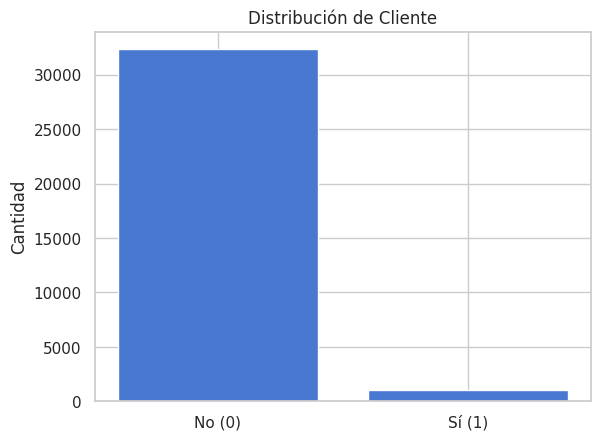

Cliente
0    32334
1     1000
Name: count, dtype: int64

In [6]:
#Analisis exploratorio
counts = df["Cliente"].value_counts().sort_index(); pct = (counts/len(df))*100; print("Distribución Cliente (conteos):\n", counts, "\n\nDistribución Cliente (%)\n", pct.round(2))
plt.figure(); plt.bar(["No (0)","Sí (1)"], counts.values); plt.title("Distribución de Cliente"); plt.ylabel("Cantidad"); plt.show()
counts.head()


Frecuencia por Stage:
 Stage
closing        8541
selling        8354
qualifying     8229
negotiating    8210
Name: count, dtype: int64


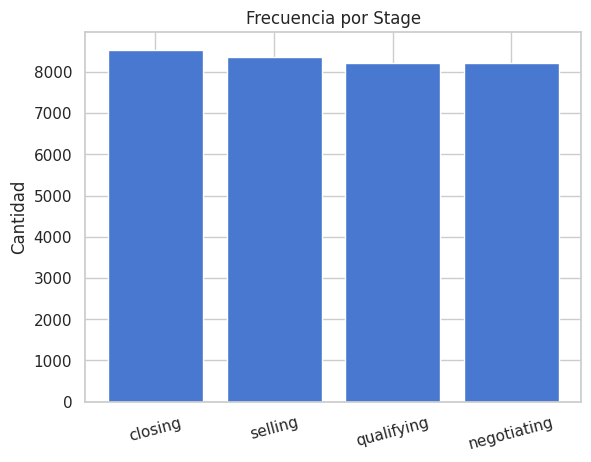

Tasa de conversión por Stage:
 Stage
closing        3.21%
qualifying     3.01%
negotiating    3.01%
selling        2.77%
Name: Cliente, dtype: object


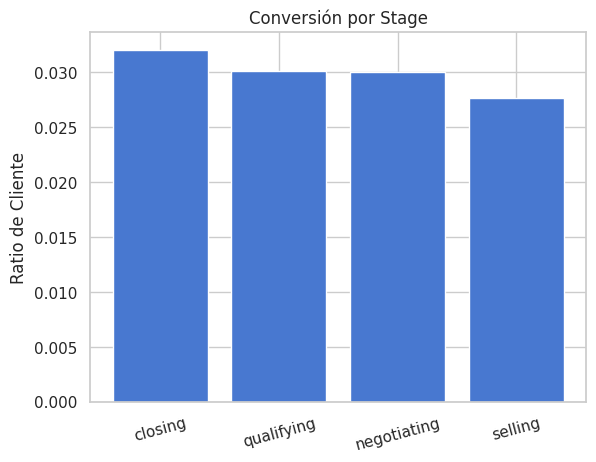

In [7]:
# ==== 2) Frecuencia por Stage (conteos totales y dónde hay más clientes) ====
stage_counts = df["Stage"].value_counts(); print("Frecuencia por Stage:\n", stage_counts)
plt.figure(); plt.bar(stage_counts.index, stage_counts.values); plt.title("Frecuencia por Stage"); plt.ylabel("Cantidad"); plt.xticks(rotation=15); plt.show()
stage_conv = df.groupby("Stage")["Cliente"].mean().sort_values(ascending=False); print("Tasa de conversión por Stage:\n", (stage_conv*100).round(2).astype(str)+"%")
plt.figure(); plt.bar(stage_conv.index, stage_conv.values); plt.title("Conversión por Stage"); plt.ylabel("Ratio de Cliente"); plt.xticks(rotation=15); plt.show()


Conversión por Sector (%):
 Sector
Educación      3.24
Tecnología     3.22
Retail         3.06
Salud          3.00
Manufactura    2.92
Servicios      2.55
Name: Cliente, dtype: float64


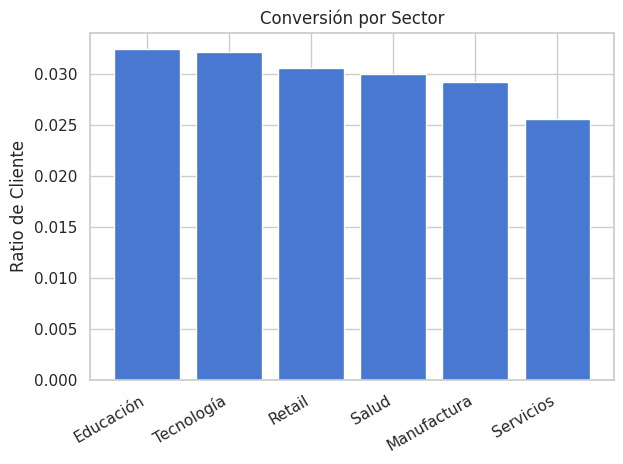

Conversión por Tamaño_Empresa (%):
 Tamaño_Empresa
Grande     3.24
Pequeña    2.99
Mediana    2.86
Name: Cliente, dtype: float64


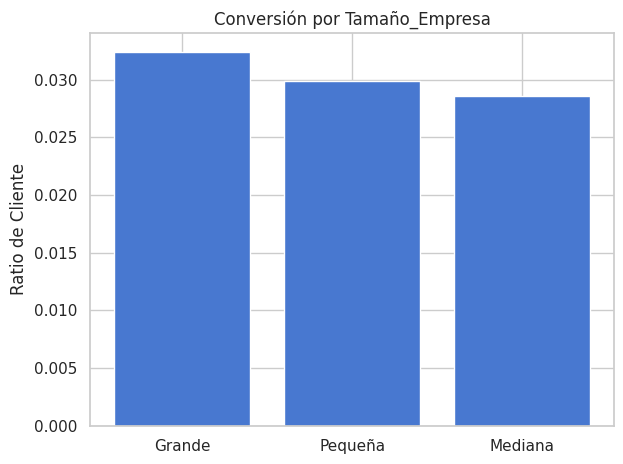

In [8]:
# ==== 3) Tasa de conversión por categoría (Sector y Tamaño_Empresa) ====
sector_conv = df.groupby("Sector")["Cliente"].mean().sort_values(ascending=False); print("Conversión por Sector (%):\n", (sector_conv*100).round(2))
plt.figure(); plt.bar(sector_conv.index, sector_conv.values); plt.title("Conversión por Sector"); plt.ylabel("Ratio de Cliente"); plt.xticks(rotation=30, ha="right"); plt.tight_layout(); plt.show()
size_conv = df.groupby("Tamaño_Empresa")["Cliente"].mean().sort_values(ascending=False); print("Conversión por Tamaño_Empresa (%):\n", (size_conv*100).round(2))
plt.figure(); plt.bar(size_conv.index, size_conv.values); plt.title("Conversión por Tamaño_Empresa"); plt.ylabel("Ratio de Cliente"); plt.xticks(rotation=0); plt.tight_layout(); plt.show()

Correlación de features numéricas con Cliente:
 Cliente                    1.000000
Interacciones_Totales      0.156626
Llamadas_Realizadas        0.144576
Visitas_Web                0.107388
Emails_Abiertos            0.051568
Presupuesto_Estimado       0.024776
Antiguedad_Cuenta_Meses   -0.000372
Name: Cliente, dtype: float64


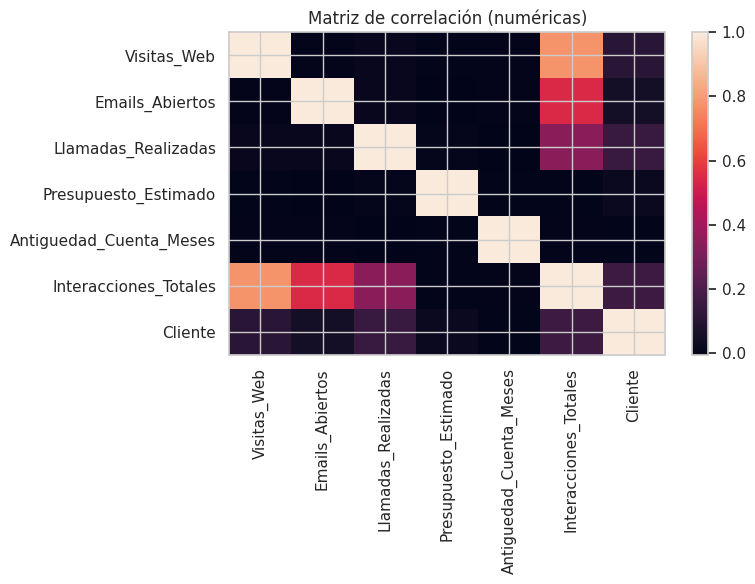

In [9]:
# ==== 4) Correlaciones (numéricas) ====
num_cols = df.select_dtypes(include=[np.number]).columns.tolist(); corr = df[num_cols].corr(); print("Correlación de features numéricas con Cliente:\n", corr["Cliente"].sort_values(ascending=False))
plt.figure(figsize=(8,6)); im = plt.imshow(corr, aspect="auto"); plt.colorbar(im); plt.xticks(range(len(num_cols)), num_cols, rotation=90); plt.yticks(range(len(num_cols)), num_cols); plt.title("Matriz de correlación (numéricas)"); plt.tight_layout(); plt.show()

Resumen percentiles (P25, P50, P75):
       Presupuesto_Estimado  Visitas_Web  Emails_Abiertos  Llamadas_Realizadas  \
0.25               12753.0          2.0              1.0                  0.0   
0.50               25212.0          3.0              2.0                  0.0   
0.75               37609.5          5.0              3.0                  1.0   

      Interacciones_Totales  
0.25                    4.0  
0.50                    6.0  
0.75                    8.0  


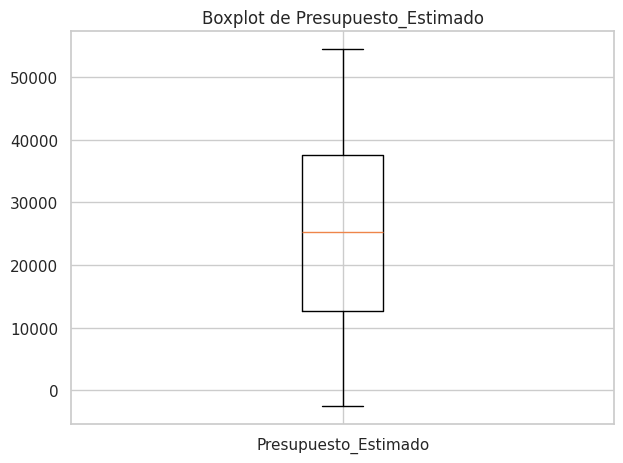

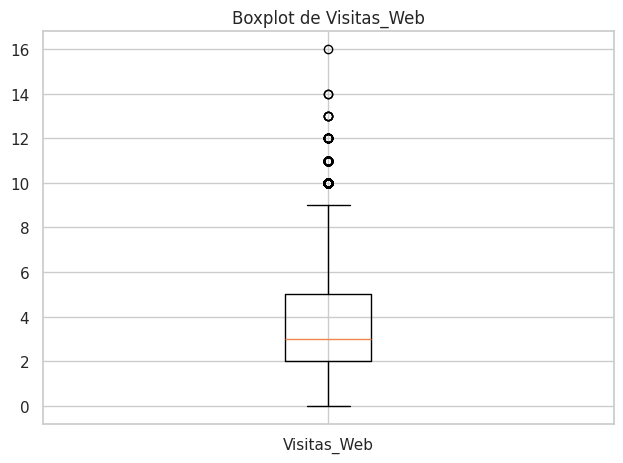

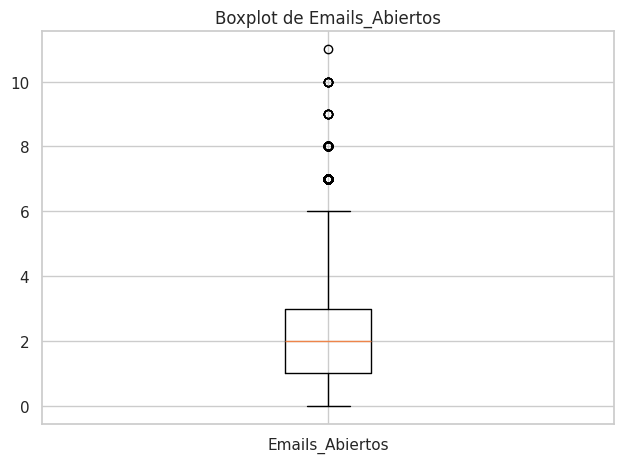

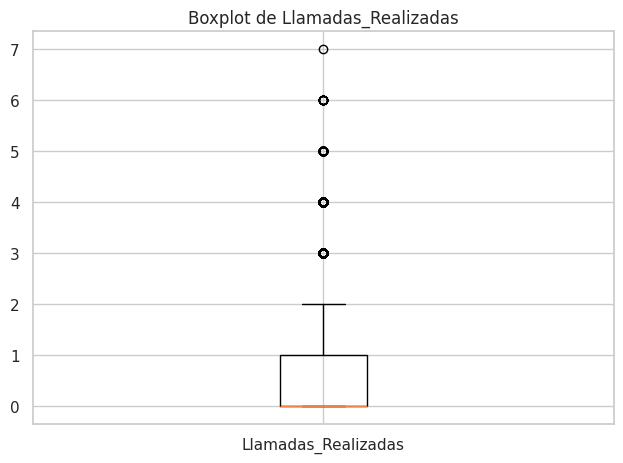

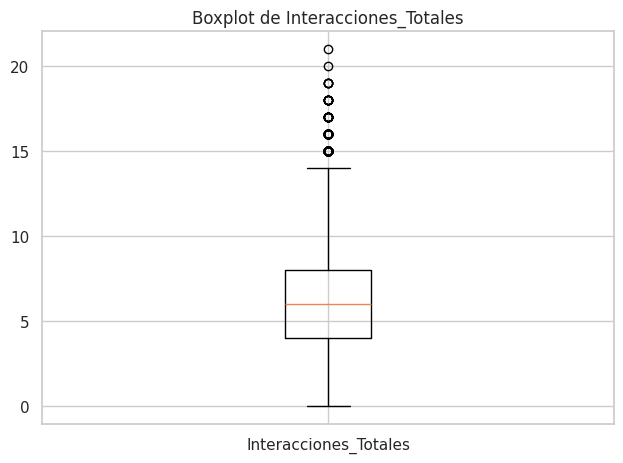

In [10]:
# ==== 5) Outliers (boxplots simples) ====
cols_out = ["Presupuesto_Estimado","Visitas_Web","Emails_Abiertos","Llamadas_Realizadas","Interacciones_Totales"]; print("Resumen percentiles (P25, P50, P75):\n", df[cols_out].quantile([0.25,0.5,0.75]))
for c in cols_out: plt.figure(); plt.boxplot(df[c].dropna(), vert=True, labels=[c]); plt.title(f"Boxplot de {c}"); plt.tight_layout(); plt.show()


Promedios por Cliente (0/1):
          Visitas_Web  Emails_Abiertos  Llamadas_Realizadas  \
Cliente                                                      
0               3.55             2.05                 0.68   
1               4.96             2.53                 1.48   

         Interacciones_Totales  Presupuesto_Estimado  Antiguedad_Cuenta_Meses  
Cliente                                                                        
0                         6.28              25149.90                    24.06  
1                         8.97              27243.36                    24.03  


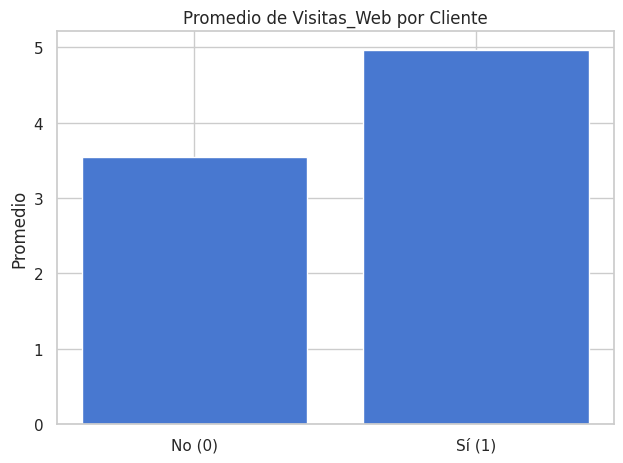

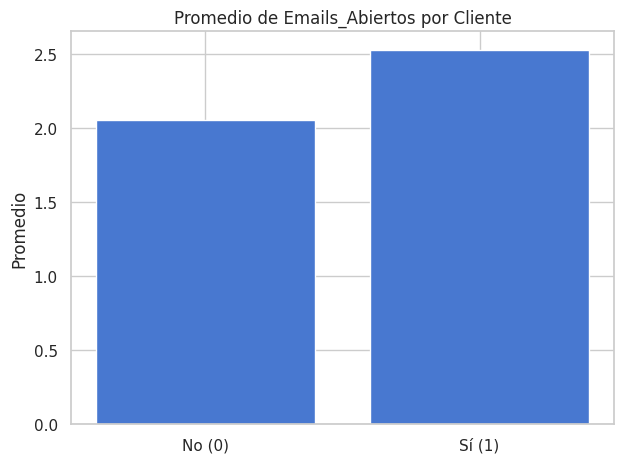

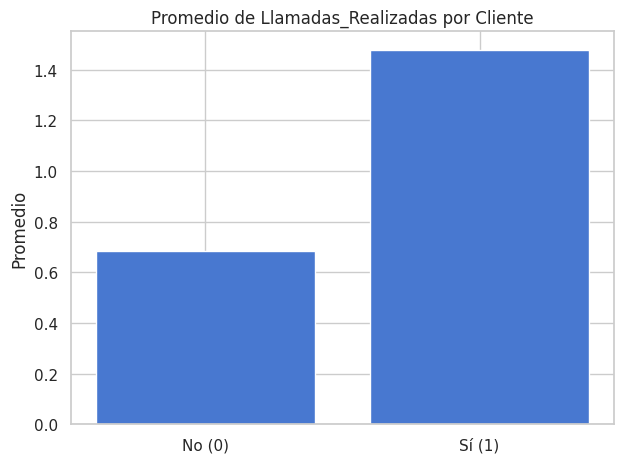

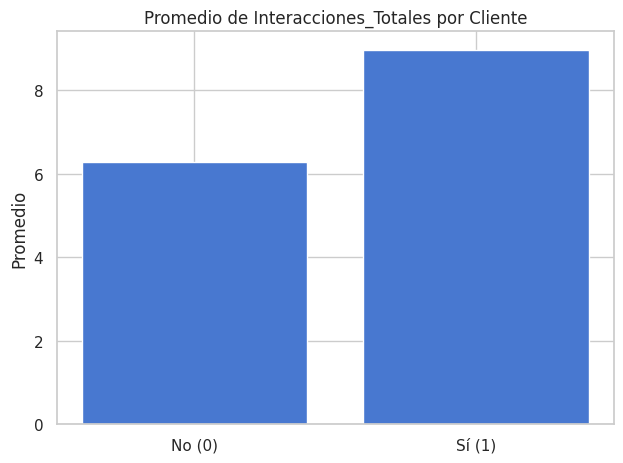

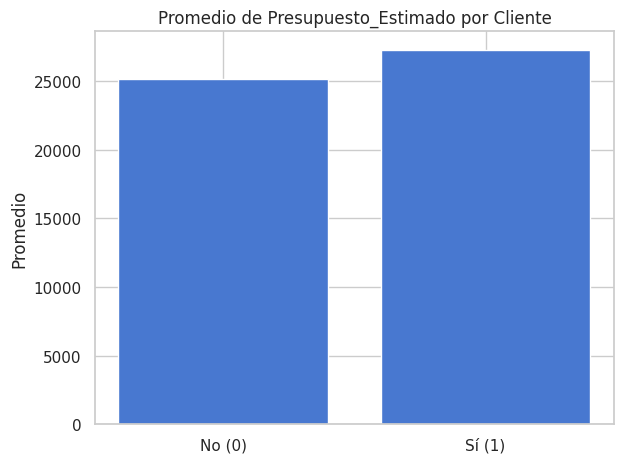

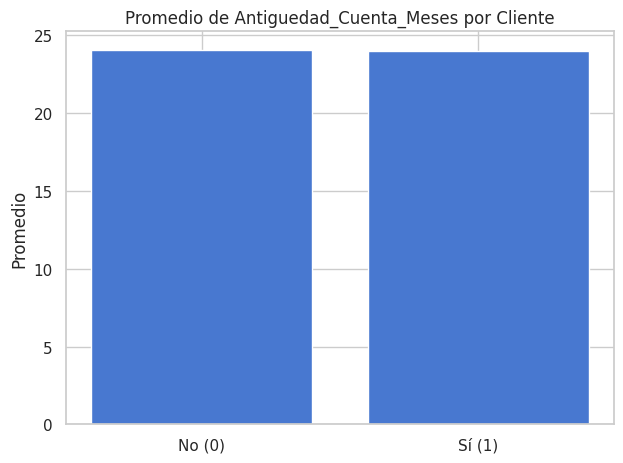

In [11]:
# ==== 6) Comparativas numéricas Cliente vs No-Cliente ====
comp_cols = ["Visitas_Web","Emails_Abiertos","Llamadas_Realizadas","Interacciones_Totales","Presupuesto_Estimado","Antiguedad_Cuenta_Meses"]; comp = df.groupby("Cliente")[comp_cols].mean().round(2); print("Promedios por Cliente (0/1):\n", comp)
for c in comp_cols: m = df.groupby("Cliente")[c].mean(); plt.figure(); plt.bar(["No (0)","Sí (1)"], m.values); plt.title(f"Promedio de {c} por Cliente"); plt.ylabel("Promedio"); plt.tight_layout(); plt.show()

In [12]:
# ==== 1) Limpieza de datos ====
# Eliminar duplicados
df = df.drop_duplicates()

# Manejar valores nulos (opción: rellenar o eliminar)
# Numéricas -> rellenamos con la mediana
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categóricas -> rellenamos con 'Desconocido'
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
df[cat_cols] = df[cat_cols].fillna("Desconocido")

# Confirmar que no haya nulos
print("Nulos por columna:\n", df.isnull().sum())

# ==== 2) Separar X (features) e y (target) ====
X = df.drop("Cliente", axis=1)
y = df["Cliente"]

# ==== 3) Identificar columnas numéricas y categóricas ====
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# ==== 4) Preparar transformadores ====
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# ==== 5) Crear pipeline con un modelo base (ej. Logistic Regression) ====
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

# ==== 6) Train/Test Split ====
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 7) Entrenar el pipeline ====
pipeline.fit(X_train, y_train)

# ==== 8) Evaluar rendimiento ====
from sklearn.metrics import classification_report, roc_auc_score

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))


Nulos por columna:
 Cuenta                     0
Contacto                   0
Puesto                     0
Celular                    0
Correo_electronico         0
Stage                      0
Visitas_Web                0
Emails_Abiertos            0
Llamadas_Realizadas        0
Presupuesto_Estimado       0
Sector                     0
Tamaño_Empresa             0
Antiguedad_Cuenta_Meses    0
Interacciones_Totales      0
Cliente                    0
dtype: int64

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      6467
           1       0.00      0.00      0.00       200

    accuracy                           0.97      6667
   macro avg       0.49      0.50      0.49      6667
weighted avg       0.94      0.97      0.96      6667

ROC-AUC: 0.7868


In [ ]:
# ==== Aplicar SMOTE y probar múltiples modelos ====
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve
import numpy as np
import pandas as pd

# Modelos a comparar
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=400, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# XGBoost y LightGBM si están instalados
try:
    from xgboost import XGBClassifier
    pos = y_train.sum(); neg = len(y_train)-pos; spw = max((neg/pos),1)
    models["XGBoost"] = XGBClassifier(
        n_estimators=500, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42, n_jobs=-1, eval_metric="aucpr",
        scale_pos_weight=spw, tree_method="hist"
    )
except:
    print("⚠️ XGBoost no disponible.")

try:
    from lightgbm import LGBMClassifier
    pos = y_train.sum(); neg = len(y_train)-pos; spw = max((neg/pos),1)
    models["LightGBM"] = LGBMClassifier(
        n_estimators=800, max_depth=-1, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42, n_jobs=-1, objective="binary",
        metric="aucpr", scale_pos_weight=spw
    )
except:
    print("⚠️ LightGBM no disponible.")

# Función para encontrar umbral óptimo basado en F1
def evaluar_modelo(y_true, y_proba):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    f1 = np.where((prec+rec) > 0, 2 * prec * rec / (prec+rec), 0)
    idx = np.argmax(f1[:-1])
    return {
        "PR-AUC": average_precision_score(y_true, y_proba),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "F1": f1[idx],
        "Precision": prec[idx],
        "Recall": rec[idx],
        "Umbral óptimo": thr[idx]
    }

# Resultados
resultados = []

for nombre, modelo in models.items():
    pipe = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", modelo)
    ])

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    metrics = evaluar_modelo(y_test, y_proba)
    resultados.append({"Modelo": nombre, **{k: round(v, 4) for k, v in metrics.items()}})

    print(f"\n=== {nombre} ===")
    print("PR-AUC:", round(metrics["PR-AUC"], 4), "| ROC-AUC:", round(metrics["ROC-AUC"], 4))
    print("F1:", round(metrics["F1"], 4), "| Precision:", round(metrics["Precision"], 4), "| Recall:", round(metrics["Recall"], 4))
    print("Umbral óptimo:", round(metrics["Umbral óptimo"], 4))

# Tabla comparativa
df_resultados = pd.DataFrame(resultados).sort_values("PR-AUC", ascending=False)
print("\n📊 Comparativa de modelos (ordenada por PR-AUC):")
print(df_resultados)



=== Logistic Regression ===
PR-AUC: 0.1056 | ROC-AUC: 0.7805
F1: 0.1873 | Precision: 0.1205 | Recall: 0.42
Umbral óptimo: 0.1345

=== Random Forest ===
PR-AUC: 0.0847 | ROC-AUC: 0.7253
F1: 0.1594 | Precision: 0.1012 | Recall: 0.375
Umbral óptimo: 0.035

=== Gradient Boosting ===
PR-AUC: 0.1161 | ROC-AUC: 0.802
F1: 0.1858 | Precision: 0.1818 | Recall: 0.19
Umbral óptimo: 0.5118

=== XGBoost ===
PR-AUC: 0.1113 | ROC-AUC: 0.7992
F1: 0.1952 | Precision: 0.1247 | Recall: 0.45
Umbral óptimo: 0.8069
[LightGBM] [Info] Number of positive: 25867, number of negative: 25867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78809
[LightGBM] [Info] Number of data points in the train set: 51734, number of used features: 3214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00

In [ ]:
#Se elige el modelo XGBoost porque quiero maximizar clientes captados, ahora vamos a darle fine tunning:
# ==================== Optuna + XGBoost: tuning por PR-AUC ====================
import optuna, numpy as np, pandas as pd, joblib, json
from sklearn.metrics import make_scorer, average_precision_score, precision_recall_curve, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Scorer de PR-AUC (average precision)
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# scale_pos_weight según train
pos = int(y_train.sum()); neg = int(len(y_train) - pos); base_spw = max(neg / max(pos,1), 1.0)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5*base_spw, 2.0*base_spw),
        "random_state": 42,
        "n_jobs": -1,
        "eval_metric": "aucpr",
        "tree_method": "hist",
    }
    clf = XGBClassifier(**params)
    pipe = Pipeline([("preprocessor", preprocessor), ("clf", clf)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, scoring=pr_auc_scorer, cv=cv, n_jobs=-1)
    return float(scores.mean())

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)
print("Mejor PR-AUC CV:", round(study.best_value,4))
print("Mejores params:", study.best_params)

# ===== Entrenar final con mejores params =====
best_params = study.best_params
best_clf = XGBClassifier(**{**best_params, "random_state":42, "n_jobs":-1, "eval_metric":"aucpr", "tree_method":"hist"})
best_pipe = Pipeline([("preprocessor", preprocessor), ("clf", best_clf)])
best_pipe.fit(X_train, y_train)

# ===== Evaluación holdout y umbral óptimo por F1 =====
y_proba = best_pipe.predict_proba(X_test)[:,1]
pr_auc = average_precision_score(y_test, y_proba); roc_auc = roc_auc_score(y_test, y_proba)
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = np.where((prec+rec)>0, 2*prec*rec/(prec+rec), 0); idx = np.argmax(f1[:-1]); thr_opt = float(thr[idx])
y_pred = (y_proba >= thr_opt).astype(int)
print(f"Holdout -> PR-AUC: {pr_auc:.4f} | ROC-AUC: {roc_auc:.4f} | Umbral* (F1): {thr_opt:.4f} | Prec*: {prec[idx]:.4f} | Rec*: {rec[idx]:.4f} | F1*: {f1[idx]:.4f}")
print("\nReporte con umbral óptimo:\n", classification_report(y_test, y_pred, digits=4))

# ===== Guardar modelo + umbral =====
joblib.dump(best_pipe, "xgb_lead_scoring_pipeline.joblib")
json.dump({"threshold": thr_opt, "best_pr_auc_cv": float(study.best_value), "best_params": best_params}, open("xgb_lead_scoring_meta.json","w"))
print("✅ Guardado: xgb_lead_scoring_pipeline.joblib y xgb_lead_scoring_meta.json")

# ===== Función de scoring para producción (ejemplo) =====
def score_leads(df_new, top_k=None):
    """Devuelve df con columnas score y pred según el umbral óptimo; ordenado desc por score."""
    p = best_pipe.predict_proba(df_new)[:,1]
    out = df_new.copy()
    out["score"] = p
    out["pred"] = (p >= thr_opt).astype(int)
    out = out.sort_values("score", ascending=False)
    return out.head(top_k) if top_k else out


[I 2025-08-12 12:16:37,454] A new study created in memory with name: no-name-89ebece5-e180-4007-9c3f-33a0ddfbe879


  0%|          | 0/50 [00:00<?, ?it/s]